<a href="https://colab.research.google.com/github/pszemraj/pubmed-text-classification/blob/analysis/notebooks/colab/run_full_dataset_Word2vec_context1_context2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ml4hc - project 2 - embedding classification



## setup

In [ ]:
%%capture
#@title set up auto-formatting of cells in notebook

from IPython.display import HTML, display


def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )
get_ipython().events.register("pre_run_cell", set_css)

In [ ]:
#@markdown force update relevant packages
!pip install -U numpy pandas matplotlib scikit-learn nltk  -q


In [ ]:
#@markdown set up logfile
import logging
logging.basicConfig(
    filename="LOGFILE_ml4hc_project2.log",
    filemode="a",
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
)
# USAGE logging.info("this message will be recorded")

In [ ]:
#@markdown check  system stats
from psutil import virtual_memory
import os
ram_gb = round(virtual_memory().total / (1024**3), 1)
logging.info(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')
print(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')

Runtime has 35.2 gigs of memory and 40 processors


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@markdown import all the things
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation, digits

from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, VarianceThreshold, f_classif)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer, confusion_matrix



import os
from string import punctuation, digits
from os import path

import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
import os
import gensim.models
from gensim.models import KeyedVectors, Word2Vec
from gensim import utils

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load data and preprocess

### define backup URLS to load data from

In [ ]:
#@markdown this cell uses the `bash` shell commands (inside jupyter) to download 
#@markdown the relevant dataset in the dropbown to the runtime. the variable `data_dir`
#@markdown points to the directory containing the files.
url_project2data_full = "https://www.dropbox.com/sh/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca?dl=1" #@param {type:"string"}
url_project2data_20k = "https://www.dropbox.com/sh/tr0jyps0qbqwo9v/AAAdfglvn1RLAza4Y2mtG33Za?dl=1" #@param {type:"string"}
data_dir = "/content/project2-data" #@param {type:"string"}
!rm -r $data_dir # clear out directory 
zip_name = "dataset.zip"
dataset = "full" #@param ["full", "20k"]
if dataset == "20k":
    # download the 20k short dataset
    !wget $url_project2data_20k -O $zip_name
    !unzip -j -q $zip_name -d $data_dir
else:
    # download the full dataset
    !wget $url_project2data_full -O $zip_name
    !unzip -j -q $zip_name -d $data_dir

print("\n" * 3, f"files in the {data_dir} directory are:")
!ls $data_dir

--2022-04-26 16:23:13--  https://www.dropbox.com/sh/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca [following]
--2022-04-26 16:23:13--  https://www.dropbox.com/sh/dl/xn85zbn7brqq35y/AAB80_k_OWttvnSjJRFgEFMca
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc96ed87b8e50ea9d77f6e68aad3.dl.dropboxusercontent.com/zip_download_get/BHjgWCtr9WsZOoYDJoJZelymyh51cN1FAXydV1i3MDKpUHE-PBd2uIa0tEJFGSCRLa2WVcZW642it2JICS519VCv9C9o7QrnAc2WSw31BbtyBA?dl=1# [following]
--2022-04-26 16:23:14--  https://uc96ed87b8e50ea9d77f6e68aad3.dl.dropboxusercontent.com/zip_download_get/BHjgWCtr9WsZOoYDJoJZelymyh51cN1FAXydV1i3MDKpUHE-PBd2uIa0tEJFGSCRLa2WVcZW642

### utilities


In [ ]:
from datetime import datetime


def get_timestamp():
    """
    get_timestamp - return a timestamp in the format YYYY-MM-DD HH-MM-SS
    """
    return datetime.now().strftime("%b-%d-%Y_%H-%M-%S")

### preprocess function

In [ ]:
#@markdown added tqdm to get a progress bar. [tqdm docs](https://tqdm.github.io/)
from tqdm.auto import tqdm 
from pathlib import Path

In [ ]:
#Load and preprocess data 
def load_split(filename, preprocess = True, stemmer = False,
               rejoin_post_stem=False):
    with open(filename, "r") as f:
        textlines = f.readlines() # renamed from 'file'
    abstract =""
    abstract_samples = []
    nb_line = 0

    base_name = Path(filename).name  # added tqdm just to show progress (this line and next)
    for sentence in tqdm(
                        textlines, # renamed from 'file'
                        total=len(textlines), 
                        desc=f"processing {base_name}", 
                    ):
        #print(sentence)
        if(sentence[:3] == ("###")):
            abstract_id = sentence
            abstract =""
            nb_line = 0
        #elif(sentence[:2] == ("\n")):
            #abstract_split = abstract.splitlines()
            
        #else:
        elif(sentence[:2] != ("\n")):
            line = {}
            sentence_split = sentence.split("\t")
            
            line["target"] = sentence_split[0]
            line["description"] = sentence_split[1].lower().replace("\n", "")
            line["line_number"] = nb_line 
            nb_line +=1
            
            if(preprocess):
                # split into words
                tokens = word_tokenize(line["description"])
                # remove punctuation from each word
                table = str.maketrans('', '', string.punctuation)
                stripped = [w.translate(table) for w in tokens]
                # remove remaining tokens that are not alphabetic
                words = [word for word in stripped if word.isalpha()]
                # filter out stop words
                stop_words = set(stopwords.words('english'))
                words = [w for w in words if not w.lower() in stop_words]
                line["preprocess"] = words

                if(stemmer):
                  stemmer_ps = PorterStemmer() 
                  stemmed_words_ps = [stemmer_ps.stem(word) for word in words]
                  # NOTE - THIS WAS ADDED. convert the stemmed list back into "normal"
                  line["preprocess"] = " ".join(stemmed_words_ps) if rejoin_post_stem else stemmed_words_ps
            
            abstract_samples.append(line)
            

    return abstract_samples

## clean & process

In [ ]:
do_preprocess = True #@param {type:"boolean"}
do_stem = True #@param {type:"boolean"}
rejoin_stemmed = False #@param {type:"boolean"}
preprocess_options = {
    "do_preprocess":do_preprocess,
    "do_stem":do_stem,
    "rejoin_stemmed":rejoin_stemmed,
}
logging.info(f"\n\nsetting preprocessing options to:\n\t{preprocess_options}")
get_timestamp()

'Apr-26-2022_16-23-27'

In [ ]:

base_path = data_dir


train_samples_preprocess = load_split(os.path.join(base_path,"train.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)
val_samples_preprocess = load_split(os.path.join(base_path,"dev.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)
test_samples_preprocess = load_split(os.path.join(base_path,"test.txt"), 
                                      preprocess=do_preprocess, stemmer = do_stem,
                                      rejoin_post_stem=rejoin_stemmed)

processing train.txt:   0%|          | 0/2593169 [00:00<?, ?it/s]

processing dev.txt:   0%|          | 0/33932 [00:00<?, ?it/s]

processing test.txt:   0%|          | 0/34493 [00:00<?, ?it/s]

In [ ]:
#Transform in dataframes 
sideload_data = True #@param {type:"boolean"}

sideload_train = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem/stemmed_processed_fulldata_TRAIN.csv" #@param {type:"string"}
sideload_val = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem/stemmed_processed_fulldata_VAL.csv" #@param {type:"string"}
sideload_test = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem/stemmed_processed_fulldata_TEST.csv" #@param {type:"string"}

if sideload_data:
    train_df = pd.read_csv(sideload_train)
    val_df = pd.read_csv(sideload_val)
    test_df = pd.read_csv(sideload_test)
    print("loaded stored data successfully")
else:
    train_df = pd.DataFrame(train_samples_preprocess).convert_dtypes()
    val_df = pd.DataFrame(val_samples_preprocess).convert_dtypes()
    test_df = pd.DataFrame(test_samples_preprocess).convert_dtypes()
train_df.head(15)

loaded stored data successfully


,target,description,line_number,preprocess
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,"['emerg', 'hiv', 'chronic', 'condit', 'mean', ..."
1,BACKGROUND,this paper describes the design and evaluation...,1,"['paper', 'describ', 'design', 'evalu', 'posit..."
2,METHODS,this study is designed as a randomised control...,2,"['studi', 'design', 'randomis', 'control', 'tr..."
3,METHODS,the intervention group will participate in the...,3,"['intervent', 'group', 'particip', 'onlin', 'g..."
4,METHODS,the program is based on self-efficacy theory a...,4,"['program', 'base', 'selfefficaci', 'theori', ..."
5,METHODS,participants will access the program for a min...,5,"['particip', 'access', 'program', 'minimum', '..."
6,METHODS,primary outcomes are domain specific self-effi...,6,"['primari', 'outcom', 'domain', 'specif', 'sel..."
7,METHODS,"secondary outcomes include : depression , anxi...",7,"['secondari', 'outcom', 'includ', 'depress', '..."
8,METHODS,"data collection will take place at baseline , ...",8,"['data', 'collect', 'take', 'place', 'baselin'..."
9,CONCLUSIONS,results of the positive outlook study will pro...,9,"['result', 'posit', 'outlook', 'studi', 'provi..."


In [ ]:
#lists of sentences
train_sentences = train_df['description'].tolist()
val_sentences = val_df['description'].tolist()
test_sentences = test_df['description'].tolist()

print(f"the first value of train is {train_sentences[0]}")


the first value of train is the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .


In [ ]:
#lists of preprocessed sentences
if not do_preprocess:
    print(f"preprocessing set to {do_preprocess}, copying description col into preprocess col")
    train_df['preprocess'] = train_df['description']
    val_df['preprocess'] = val_df['description']
    test_df['preprocess'] = test_df['description']
train_sentences_prep = train_df['preprocess'].tolist()
val_sentences_prep = val_df['preprocess'].tolist()
test_sentences_prep = test_df['preprocess'].tolist()

print(f"the first value of train is {train_sentences_prep[0]}")

the first value of train is ['emerg', 'hiv', 'chronic', 'condit', 'mean', 'peopl', 'live', 'hiv', 'requir', 'take', 'respons', 'selfmanag', 'condit', 'includ', 'make', 'physic', 'emot', 'social', 'adjust']


In [ ]:
#lists of targets
labels_train = train_df['target'].tolist()
labels_val = val_df['target'].tolist()
labels_test = test_df['target'].tolist()

In [ ]:
label_map = {
    'BACKGROUND': 0,
    'CONCLUSIONS': 1,
    'METHODS': 2,
    'OBJECTIVE': 3,
    'RESULTS': 4,
}

In [ ]:
#Encode labels
train_labels = np.asarray([label_map[label] for label in labels_train])
val_labels = np.asarray([label_map[label] for label in labels_val])
test_labels = np.asarray([label_map[label] for label in labels_test])

<AxesSubplot:ylabel='count'>

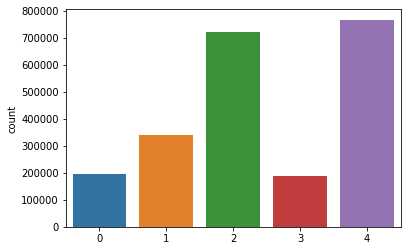

In [ ]:
sns.countplot(x=train_labels)

##Save preprocessed 

In [ ]:
import csv
path_base = ('drive/MyDrive/ETH')
train_df['preprocess'].to_csv(os.path.join(path_base,"train_sentences_prep.csv")) 
test_df['preprocess'].to_csv(os.path.join(path_base,"test_sentences_prep.csv")) 
val_df['preprocess'].to_csv(os.path.join(path_base,"val_sentences_prep.csv")) 
#np.savetxt(os.path.join(base_path,"train_sentences_prep.csv"), train_sentences_prep,delimiter =", ", fmt ='% s')
#train_sentences_prep 

FileNotFoundError: ignored

In [ ]:
path_base = ('drive/MyDrive/ETH')
train_sentences_prep = pd.read_csv(os.path.join(path_base,"train_sentences_prep.csv"))['preprocess']
test_sentences_prep = pd.read_csv(os.path.join(path_base,"test_sentences_prep.csv"))['preprocess']
val_sentences_prep = pd.read_csv(os.path.join(path_base,"val_sentences_prep.csv"))['preprocess']

In [ ]:
from gensim.test.utils import get_tmpfile

fname = get_tmpfile(os.path.join(path_base,"fasttext100.model"))
#ft_model.save(os.path.join(path_base,"fasttext100.model"))

#model = FastText.load(fname)

## Task 1: Baseline Model 

### Classifiers

In [ ]:
# MLP
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(50,), activation='tanh',
                    random_state=1)

In [ ]:
# Logistic Regression
LR = LogisticRegression(
    verbose=0,
    class_weight = "balanced",
    random_state = 0,
    multi_class = "multinomial",
    max_iter=100 ** 2,
    n_jobs=os.cpu_count(),
)

In [ ]:
#%%time
# Create a pipeline
baseline = Pipeline([
  ("tf-idf", TfidfVectorizer(lowercase=False, tokenizer=lambda i:i)),
   #TfidfVectorizer(lowercase=False)),
  ("clf", LR)
])

baseline.fit(X=train_sentences_prep, 
            y=train_labels);

In [ ]:
# Evaluate on validation set
val_score = baseline.score(X=test_sentences_prep,
              y=test_labels)
val_score = round(val_score, 4)
logging.info(f"received score of {val_score} on validation with MLP with settings:\n\t{preprocess_options}")
val_score

0.0904

In [ ]:
# Make predictions
y_pred = baseline.predict(test_sentences_prep)
f_score = f1_score(test_labels, y_pred, average="weighted")
f_score = round(f_score, 4)

logging.info(f"received f1_score of {f_score} on test set with with LR settings:\n\t{preprocess_options}")

f_score

0.0152

In [ ]:
#Store predictions 
model_name = 'MLP'
np.save(f"./MLP_test_{model_name}.npy", y_pred, allow_pickle=True)

In [ ]:
#Analyse the confusion matrix 
confusion_matrix(test_labels, y_pred)

array([[1353,  431,  266,  455,  158],
       [ 375, 2916,  242,  146,  747],
       [ 107,  197, 8545,  147,  755],
       [ 474,  210,  345, 1257,   91],
       [  82,  548, 1083,   42, 8521]])

In [ ]:
#F_score = 0.7072 for MLP

#LR : 
confusion_matrix = array([[1501,  345,  130,  618,   69],
       [ 564, 3039,  138,  282,  403],
       [ 253,  282, 8214,  407,  595],
       [ 487,  171,  156, 1526,   37],
       [ 214,  949, 1047,  148, 7918]])
f_score = 0.758

#MLP 
f_score = 0.7925
array([[1498,  381,  207,  445,  132],
       [ 369, 3045,  181,  117,  714],
       [  86,  129, 8827,  140,  569],
       [ 487,  186,  255, 1380,   69],
       [  90,  509,  944,   41, 8692]])

NameError: ignored

### Prepare the data for the NN

In [ ]:
from tensorflow.keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate,Flatten,\
Dense,Dropout,LSTM,Masking,Bidirectional,Dropout,GRU,SimpleRNN,TimeDistributed, BatchNormalization, Activation, MaxPooling1D, GlobalMaxPooling1D, Conv1D
from keras.models import Sequential,Model
from keras.utils import np_utils
from sklearn.utils.class_weight import compute_class_weight
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(train_labels)
y = np_utils.to_categorical(y)

y_val = lb.fit_transform(val_labels)
y_val = np_utils.to_categorical(y_val)

In [ ]:
max_f = 80
tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda i:i, max_features=max_f)
tfidf_train = tfidf.fit_transform(train_sentences_prep).todense()
tfidf_test = tfidf.fit_transform(test_sentences_prep).todense()
tfidf_val = tfidf.fit_transform(val_sentences_prep).todense()

In [ ]:
# Model Training 
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=max_f, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=5)


print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=256)
estimator.fit(tfidf_train, 
                      y, 
                      batch_size=256, 
                      epochs=5,
                      validation_data=(tfidf_val, y_val),
                      callbacks=[early_stop])

# Predictions 
print ("Predict on test data ... ")
y_pred = estimator.predict(tfidf_test)
f_score = f1_score(test_labels, y_pred, average="weighted")
print('f_score' , f_score)

Reminder ('BACKGROUND': 0,'CONCLUSIONS': 1,'METHODS': 2,'OBJECTIVE': 3,'RESULTS': 4)

Major confusions : 
- classified as Background instead of objective
- classified as conclusion instead of background
- classified as method instead of results
- classified as Background instead of objective
- classified as results instead of method or objective

### logfile after Task 1

In [ ]:
!cat /content/LOGFILE_ml4hc_project2.log

We get better results by using the sentences (train_sentences) directly without preprocessing (except lowercase) rather than using the preprocessed sentences (train_sentences_prep).
20K dataset, on test set :
    - without preprocessing : f1_score = 0.791 
    - with preprocessing (without stemming) : f1_score = 0.759
    - with preprocessing (with stemming) : f1_score = 0.738

# Task 2 : Word Embedding

- link to the medium article [here](https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381)

In [ ]:
from gensim.models.fasttext import FastText

In [ ]:
size = 10 #@param {type:"integer"}
project_root = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2" #@param {type:"string"}
project_root = Path(project_root)

project_root.resolve()

PosixPath('/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2')

## model fitting

In [ ]:
output_dir = project_root / "fulldata_context_stem"
output_dir.mkdir(exist_ok=True)
print(f"Note: outputs will be saved to:\n\t{output_dir}")

Note: outputs will be saved to:
	/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem


In [ ]:
ft_size = size
ft_model = FastText(sentences = train_sentences_prep,   # list of tokenized sentences
                                workers = max(os.cpu_count()-2, 1),                         # Number of threads to run in parallel
                                iter = 5,                       # Number of epochs
                                size = ft_size ,                          # Word vector dimensionality     
                                # min_count=2,
                                # window=10,
                        )

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences = train_sentences_prep,   # list of tokenized sentences
                               workers = max(os.cpu_count()-2, 1),                         # Number of threads to run in parallel
                               iter = 5,                       # Number of epochs
                               size = size,                          # Word vector dimensionality     
                               )

In [ ]:
#size100
# ft_model = FastText.load(os.path.join(path_base,"fasttext100.model"))

In [ ]:
%%time
#save fasttext model
import joblib
import pickle
joblib.dump(ft_model,
            output_dir / f"ft_model_sz={ft_size}_mc2_w10.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 4.68 ms, sys: 0 ns, total: 4.68 ms
Wall time: 11.4 ms


In [ ]:
%%time
#save w2v_model

import joblib
import pickle
joblib.dump(w2v_model,
            output_dir / f"w2v_model_size={size}.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def sentence_embedd_average(model,data):
    x = []
    for index in range(len(data)):
        # remove out-of-vocabulary words
        doc = [word for word in data[index] if word in model.wv.vocab.keys()]
        if not doc:
            # append zero vector
            x.append(np.zeros(size))

        else:
            # append the average vector for each sentence
            x.append(np.mean(model[doc], axis=0))
        
    X = np.array(x)

    return X

In [ ]:
Xtrain_av = sentence_embedd_average(ft_model, train_sentences_prep)
Xval_av = sentence_embedd_average(ft_model, val_sentences_prep)
Xtest_av = sentence_embedd_average(ft_model, test_sentences_prep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
def sentence_embedd_concatenate(model,data):
    x = []
    maxwords = max([len(train_sentences_prep[i]) for i in range(len(train_sentences_prep))])
    for index in range(len(data)):
        # remove out-of-vocabulary words
        doc = [word for word in data[index] if word in model.wv.vocab.keys()]
        if not doc:
            # append zero vector
            x.append(np.zeros((maxwords,size)))

        else:
            # append the average vector for each sentence
            sentence = np.array(model[doc])
            #x.append(np.array(model[doc], dtype=object))
            #print(len(model[doc]))
            if len(model[doc]) < maxwords:
              sentence = np.append(sentence, np.zeros(((maxwords-len(model[doc])),size)), axis=0)
              #print(len(sentence))
            x.append(np.array(sentence))
            
        
    X = np.array(x)
    return X

In [ ]:
Xtrain_conc = sentence_embedd_concatenate(w2v_model, train_sentences_prep)
Xval_conc = sentence_embedd_concatenate(w2v_model, val_sentences_prep)
Xtest_conc = sentence_embedd_concatenate(w2v_model, test_sentences_prep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
#Reshape 
Xtrain_conc = Xtrain_conc.reshape((Xtrain_conc.shape[0], Xtrain_conc.shape[1]*Xtrain_conc.shape[2]))
Xval_conc = Xval_conc.reshape((Xval_conc.shape[0], Xval_conc.shape[1]*Xval_conc.shape[2]))
Xtest_conc = Xtest_conc.reshape((Xtest_conc.shape[0], Xtest_conc.shape[1]*Xtest_conc.shape[2]))

### context 1


In [ ]:
from tqdm.auto import tqdm # progress bar cause it takes forever

def context1_embedd_average(w2v_model,train_df):
    x = []
    _num_sentences = len(train_df['preprocess'])
    for index in tqdm(range(_num_sentences), total=_num_sentences):
        # remove out-of-vocabulary words
        #print(index)
        if (index >1) and (index<(len(train_df)-1)):
         # print('here')
          #print(train_df['line_number'][index-1])
          if (train_df['line_number'][index-1] < train_df['line_number'][index]) :
            prev_context = [word for word in train_df['preprocess'][index-1] if word in w2v_model.wv.vocab.keys()]
          else : prev_context=[]

          if (train_df['line_number'][index+1] > train_df['line_number'][index]) :
            next_context = [word for word in train_df['preprocess'][index+1] if word in w2v_model.wv.vocab.keys()]
          else : next_context=[]
        else :
          prev_context=[]
          next_context=[]
        sentence = [word for word in train_df['preprocess'][index] if word in w2v_model.wv.vocab.keys()]
        

        if not prev_context : prev_context= np.zeros(size)
        else : prev_context = np.mean(w2v_model[prev_context], axis=0)

        if not next_context : next_context= np.zeros(size)
        else : next_context = np.mean(w2v_model[next_context], axis=0)

        if not sentence : sentence= np.zeros(size)
        else : sentence = np.mean(w2v_model[sentence], axis=0)       

        doc = [prev_context, sentence, next_context]
            
        x.append(doc)
        
    X = np.array(x)


    return X

In [ ]:
Xtrain_context1 = context1_embedd_average(w2v_model, train_df)
Xval_context1 = context1_embedd_average(w2v_model, val_df)
Xtest_context1 = context1_embedd_average(w2v_model, test_df)

  0%|          | 0/2211861 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


  0%|          | 0/28932 [00:00<?, ?it/s]

  0%|          | 0/29493 [00:00<?, ?it/s]

In [ ]:
#Reshape 
Xtrain_context1 = Xtrain_context1.reshape((Xtrain_context1.shape[0], Xtrain_context1.shape[1]*Xtrain_context1.shape[2]))
Xval_context1 = Xval_context1.reshape((Xval_context1.shape[0], Xval_context1.shape[1]*Xval_context1.shape[2]))
Xtest_context1 = Xtest_context1.reshape((Xtest_context1.shape[0], Xtest_context1.shape[1]*Xtest_context1.shape[2]))

In [ ]:
context1_trainset = {
    "Xtrain_context1":Xtrain_context1, 
    "Xval_context1":Xval_context1, 
    "Xtest_context1":Xtest_context1,
}

for name, var in context1_trainset.items():

    joblib.dump(var,
            output_dir / f"context1_set_embedded_reshaped_{name}_sz={size}.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL,
        )


In [ ]:
# save just in case

joblib.dump(w2v_model,
            output_dir / f"w2v_model_size={size}.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL)

['/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem/w2v_model_size=10.pkl']

### context 2


In [ ]:
from tqdm.auto import tqdm # progress bar cause it takes forever

def context2_embedd_average(w2v_model,train_df):
    x = []
    _num_sentences = len(train_df['preprocess'])
    for index in tqdm(range(_num_sentences), total=_num_sentences):
        # remove out-of-vocabulary words
        #print(index)
        if (index >1) and (index<(len(train_df)-1)):
          if (train_df['line_number'][index-1] < train_df['line_number'][index]) :
            prev_context1 = [word for word in train_df['preprocess'][index-1] if word in w2v_model.wv.vocab.keys()]
          else : prev_context1=[]

          if (train_df['line_number'][index+1] > train_df['line_number'][index]) :
            next_context1 = [word for word in train_df['preprocess'][index+1] if word in w2v_model.wv.vocab.keys()]
          else : next_context1=[]

        if (index >2) and (index<(len(train_df)-2)):
          if (train_df['line_number'][index-2] < train_df['line_number'][index]) :
            prev_context2 = [word for word in train_df['preprocess'][index-2] if word in w2v_model.wv.vocab.keys()]
          else : prev_context2=[]
          if (train_df['line_number'][index+2] < train_df['line_number'][index]) :
            next_context2 = [word for word in train_df['preprocess'][index+2] if word in w2v_model.wv.vocab.keys()]
          else : next_context2=[]

          
        else :
          prev_context1=[]
          next_context1=[]
          prev_context2=[]
          next_context2=[]

        sentence = [word for word in train_df['preprocess'][index] if word in w2v_model.wv.vocab.keys()]
        

        if not prev_context1 : prev_context1= np.zeros(size)
        else : prev_context1 = np.mean(w2v_model[prev_context1], axis=0)

        if not next_context1 : next_context1= np.zeros(size)
        else : next_context1 = np.mean(w2v_model[next_context1], axis=0)

        if not prev_context2 : prev_context2= np.zeros(size)
        else : prev_context2 = np.mean(w2v_model[prev_context2], axis=0)

        if not next_context2 : next_context2= np.zeros(size)
        else : next_context2 = np.mean(w2v_model[next_context2], axis=0)

        if not sentence : sentence= np.zeros(size)
        else : sentence = np.mean(w2v_model[sentence], axis=0)       

        doc = [prev_context2, prev_context1, sentence, next_context1, next_context2]
            
        x.append(doc)
        
    X = np.array(x)


    return X

In [ ]:
Xtrain_context2 = context2_embedd_average(ft_model, train_df)
Xval_context2 = context2_embedd_average(ft_model, val_df)
Xtest_context2 = context2_embedd_average(ft_model, test_df)

  0%|          | 0/2211861 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


  0%|          | 0/28932 [00:00<?, ?it/s]

  0%|          | 0/29493 [00:00<?, ?it/s]

In [ ]:
#Reshape 
Xtrain_context2 = Xtrain_context2.reshape((Xtrain_context2.shape[0], Xtrain_context2.shape[1]*Xtrain_context2.shape[2]))
Xval_context2 = Xval_context2.reshape((Xval_context2.shape[0], Xval_context2.shape[1]*Xval_context2.shape[2]))
Xtest_context2 = Xtest_context2.reshape((Xtest_context2.shape[0], Xtest_context2.shape[1]*Xtest_context2.shape[2]))

In [ ]:
context2_trainset = {
    "Xtrain_context2":Xtrain_context2, 
    "Xval_context2":Xval_context2, 
    "Xtest_context2":Xtest_context2,
}
for name, var in context2_trainset.items():
    
    joblib.dump(var,
            output_dir / f"context2_set_embedded_reshaped_{name}_sz={ft_size}.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL,
        )


In [ ]:
# save just in case

joblib.dump(ft_model,
            output_dir / f"ft_model_postembed_sz={ft_size}.pkl",
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL)

['/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/fulldata_context_stem/ft_model_postembed_sz=10.pkl']

## classification

### Classifier - context 1

In [95]:
%%time
lr = LogisticRegression(max_iter=500,
                        tol=1e-3,
                        # class_weight='balanced',
                        n_jobs=max(os.cpu_count()-2,1),
                    )
lr.fit(Xtrain_context1, train_labels)

CPU times: user 2.25 s, sys: 8.55 s, total: 10.8 s
Wall time: 7min 6s


In [96]:
# Make predictions
y_preds = lr.predict(Xtest_context1)
f1 = f1_score(test_labels, y_preds, average='weighted')
print('LogReg f1 score weighted : {}',f1)

#Context1 : fscore = 0.7749
#Context2 : fscore = 0.8049

#fasttext context2 : fscore = 0.8358

# word2 vec full dataset score
# fulldataset LogReg f1 score weighted : {} 0.6717911213174758 context1  # class_weight='balanced', in LR
# ran it a second time with balanced commented out LogReg f1 score weighted : {} 0.6717911213174758

LogReg f1 score weighted : {} 0.7708552285639891


In [97]:
## serialize files

context1_results = {
    "lr_model":lr, 
    "y_pred_context1":y_preds, 
}

for name, var in context1_results.items():
    outpath=output_dir / f"context1_set_results_{name}_size={size}.pkl"
    if outpath.exists() and outpath.is_file():
        outpath = output_dir / f"NewVersion_{outpath.name}"
    joblib.dump(var,
            outpath,
            compress=True,
            protocol=pickle.HIGHEST_PROTOCOL,
        )


In [98]:
#with stemming
#W2VEC
#Average fscore = 0.705
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 0.7684
#context2 with size=10 and logreg 1000 = 0.8043

#Fasttext
#Average fscore = 0.694
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 
#context2 with size=10 and logreg 1000 = 

In [ ]:
#without stemming 
#W2VEC
#Average fscore = 0.733
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 
#context2 with size=10 and logreg 1000 =

#Fasttext
#Average fscore = 0.718
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 0.628
#context2 with size=10 and logreg 1000 = 0.6915

#### autoML context 1

In [ ]:
!pip install -U flaml[notebook] -q


In [100]:
from flaml import AutoML


In [105]:
automl = AutoML()
from flaml.model import LGBMEstimator, XGBoostEstimator

automl.add_learner("mylgbm", LGBMEstimator)
automl.add_learner("papa_boost", XGBoostEstimator)


logname = "pubmed_test.log"
# TODO: try to_numpy()
settings = {
    "time_budget": 120,  # in seconds
    "metric": 'macro_f1', 
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'classification',  # task type    
    "log_file_name": logname,
}


In [106]:
# automl.fit(X_train, y_train, time_budget=600, task="regression")
import os
automl.fit(Xtrain_context1, train_labels, 
           **settings,
           verbose=False,
           early_stop=True,
)

In [107]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))


Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 918, 'num_leaves': 54, 'min_child_samples': 23, 'learning_rate': 0.09987591599349882, 'log_max_bin': 6, 'colsample_bytree': 0.45327713616378634, 'reg_alpha': 0.0034922118383222253, 'reg_lambda': 0.0015565068799621952, 'FLAML_sample_size': 1990675}
Best accuracy on validation data: 0.7664
Training duration of best run: 103.6 s


In [108]:
'''pickle and save the automl object'''
import pickle
model1_path = output_dir / 'automl_context1_lgbm.pkl'
with open(model1_path, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open(model1_path, 'rb') as f:
    automl = pickle.load(f)

In [109]:
y_pred = automl.predict(Xtest_context1)
f1 = f1_score(test_labels, y_pred, average='weighted')
print('LogReg f1 score weighted : {}',f1)

LogReg f1 score weighted : {} 0.827796579097642


### Classifier - context 2



In [ ]:
%%time
lr = LogisticRegression(max_iter=500,
                        tol=1e-3,
                        n_jobs=max(os.cpu_count()-2,1),
                    )
lr.fit(Xtrain_context2, train_labels)

CPU times: user 3.75 s, sys: 8.57 s, total: 12.3 s
Wall time: 15min 17s


In [ ]:
# Make predictions
y_preds = lr.predict(Xtest_context2)
f1 = f1_score(test_labels, y_preds, average='weighted')
print('LogReg f1 score weighted : {}',f1)

#Context1 : fscore = 0.7749
#Context2 : fscore = 0.8049

#fasttext context2 : fscore = 0.8358

LogReg f1 score weighted : {} 0.5896887038009822


In [ ]:
context2_results = {
    "lr_model":lr, 
    "y_pred_context2":y_preds, 
}
for name, var in context1_results.items():
    outpath = output_dir / f"context2_set_results_{name}_size={ft_size}.pkl"
    if outpath.exists() and outpath.is_file():
        outpath = output_dir / f"NewVersion_{outpath.name}"
    joblib.dump(var,
                outpath,
                compress=True,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

In [ ]:
logging.info(f"f1 score is {f1}")
import shutil
shutil.copy(_das_logfile, output_dir / _das_logfile.name)


In [ ]:
lname = "LOGFILE_ml4hc_project2.log"
shutil.copy(lname, output_dir / lname)



In [ ]:
#with stemming
#W2VEC
#Average fscore = 0.705
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 0.7684
#context2 with size=10 and logreg 1000 = 0.8043

#Fasttext
#Average fscore = 0.694
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 
#context2 with size=10 and logreg 1000 = 

In [ ]:
#without stemming 
#W2VEC
#Average fscore = 0.733
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 
#context2 with size=10 and logreg 1000 =

#Fasttext
#Average fscore = 0.718
#concatenate fscore = 
#context1 with size=10 and logreg 1000 = 0.628
#context2 with size=10 and logreg 1000 = 0.6915

#### autoML context 2

In [112]:
automl_c2 = AutoML()


In [113]:
automl_c2.fit(Xtrain_context2, train_labels, 
           **settings,
           verbose=False,
           early_stop=True,
)

In [116]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl_c2.best_estimator)
print('Best hyperparmeter config:', automl_c2.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl_c2.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_c2.best_config_train_time))


Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 270, 'num_leaves': 9, 'min_child_samples': 5, 'learning_rate': 0.1967016673936409, 'log_max_bin': 10, 'colsample_bytree': 0.8846955755228798, 'reg_alpha': 0.004996244283600559, 'reg_lambda': 3.5813940414439145, 'FLAML_sample_size': 1990675}
Best accuracy on validation data: 0.6314
Training duration of best run: 42.55 s


In [117]:
'''pickle and save the automl object'''
import pickle
model2_path = output_dir / 'automl_context2_lgbm.pkl'
with open(model2_path, 'wb') as f:
    pickle.dump(automl_c2, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open(model2_path, 'rb') as f:
    automl_c2 = pickle.load(f)

In [118]:
y_pred = automl_c2.predict(Xtest_context2)
f1 = f1_score(test_labels, y_pred, average='weighted')
print('LogReg f1 score weighted : {}',f1)

LogReg f1 score weighted : {} 0.657099338144025


### Results